<u><h1>Testing Q-Learning on a simple example</u>

In [1]:
# Import packages
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random

/var/folders/2h/swncbcrs3q71pyydxx4wrls00000gn/T/ipykernel_1201/2169152704.py:7: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  self.fig.canvas.set_window_title('RL')


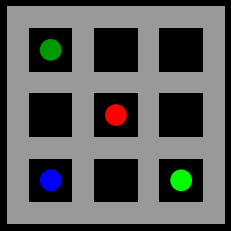

In [2]:
# Draw environment
class Environment:
    def __init__(self, width, height, agent_pos, small_reward_pos, big_reward_pos, threat_pos):
        plt.ion()
        plt.show()
        self.fig,self.axes = plt.subplots(1,1)
        self.fig.canvas.set_window_title('RL')
        matplotlib.rcParams['toolbar'] = 'None'
        self.w = width*3+1
        self.h = height*3+1
        self.canvas = None
        self.grid = np.zeros((self.w, self.h))

        for x in range(self.w):
           self.grid[x][0] = 10
           self.grid[x][self.h-1] = 10
           for y in range(self.h):
               if x % 3 == 0:
                   self.grid[x][y] = 10
               if y % 3==0:
                   self.grid[x][y] = 10

        for y in range(self.h):
           self.grid[self.w-1][y] = 10
           self.grid[0][y] = 10

        self.draw(agent_pos, small_reward_pos, big_reward_pos, threat_pos)

    def draw(self, agent_pos, small_reward_pos, big_reward_pos, threat_pos):
        self.axes.clear()

        plt.xlim(0,self.w)
        plt.ylim(0,self.h)
        plt.axis('off')
        self.fig.patch.set_facecolor((0,0,0))

        self.axes.set_aspect(1)

        borders = []
        for x in range (self.w):
           for y in range (self.h):
               if self.grid[x][y] == 10:
                   borders.append(  plt.Rectangle((x,y), width = 1, height = 1 ) )

        self.axes.add_collection (  matplotlib.collections.PatchCollection(borders,  facecolors = (0.6, 0.6, 0.6)) )

        self.axes.add_patch(plt.Circle((agent_pos[0]*3+1+1,agent_pos[1]*3+1+1), radius= 0.5, facecolor = (0, 0, 1.0) ))
        self.axes.add_patch(plt.Circle((small_reward_pos[0]*3+1+1,small_reward_pos[1]*3+1+1), radius= 0.5, facecolor = (0, 0.6, 0) ))
        self.axes.add_patch(plt.Circle((big_reward_pos[0]*3+1+1,big_reward_pos[1]*3+1+1), radius= 0.5, facecolor = (0, 1.0, 0) ))
        self.axes.add_patch(plt.Circle((threat_pos[0]*3+1+1,threat_pos[1]*3+1+1), radius= 0.5, facecolor = (1.0, 0, 0) ))

        self.fig.canvas.draw()
        self.fig.canvas.flush_events()

width = 3
height= 3
e = Environment(width, height, [0,0], [0,2], [2,0], [1,1])

In [3]:
class Policy:
    def __init__(self):
        self.Q_table = {}
        for i in range(width):
            for j in range(height):
                self.Q_table[str([i,j])] = {str([-1,0]): 0.0, str([1,0]):0.0, str([0,-1]):0.0, str([0,1]):0.0}
        self.epsilon_greedy = 1.0
        self.decay = 0.9999
        self.min_epsilon = 0.1
        self.learning_rate = 0.6
        self.discount = 0.9

    def update_table(self, previous_pos, move, new_pos, reward):
        self.Q_table[str(previous_pos)][str(move)] = (1-self.learning_rate)*self.Q_table[str(previous_pos)][str(move)]+self.learning_rate*(reward+self.discount*max(list(self.Q_table[str(new_pos)].values())))

    def choose_move(self, agent_pos, possible_moves):
        random_val = random.random()
        if random_val >= self.epsilon_greedy:
            q_values = []
            for possible_move in possible_moves:
                q_values.append(self.Q_table[str(agent_pos)][str(possible_move)])
            move = possible_moves[np.argmax(q_values)]
        else:
            move = random.choice(possible_moves)
        return move

In [4]:
class Episode:
    def __init__(self):
        # Create Agent, Rewards and Threats
        self.agent_pos = [0,0]
        self.small_reward_pos = [0,2]
        self.big_reward_pos = [2,0]
        self.threat_pos = [1,1]
        self.end_episode = False
        # Initialize environment
        # Not really useful in Jupyter Notebook
        #self.env = Environment(width, height, self.agent_pos, self.small_reward_pos, self.big_reward_pos, self.threat_pos)

    def possible_moves(self):
        possible_movements = []
        if self.agent_pos[0] < width-1:
            possible_movements.append([1,0])
        if self.agent_pos[0] > 1:
            possible_movements.append([-1,0])
        if self.agent_pos[1] < height-1:
            possible_movements.append([0,1])
        if self.agent_pos[1] > 1:
            possible_movements.append([0,-1])
        return possible_movements

    def move(self, move):
        previous_pos = [self.agent_pos[0], self.agent_pos[1]]
        self.agent_pos[0] += move[0]
        self.agent_pos[1] += move[1]
        reward = self.check_game_state()
        # Not really useful in Jupyter Notebook
        #self.env.draw(self.agent_pos, self.small_reward_pos, self.big_reward_pos, self.threat_pos)
        return [previous_pos, move, self.agent_pos, reward]

    def check_game_state(self):
        if self.agent_pos == self.big_reward_pos:
            reward = 10
            self.end_episode = True
        elif self.agent_pos == self.threat_pos:
            reward = -10
            self.end_episode = True
        elif self.agent_pos == self.small_reward_pos:
            reward = 1
        else:
            reward = -1
        return reward

In [5]:
def pretty_print_table(table):
    for k in list(table[str([0,0])].keys()):
        print("      ", k, end="      ")
    print("")
    for k,d in table.items():
        print(k, end="   ")
        for v in list(d.values()):
            print(round(v,2), end="                 ")
        print("")

In [6]:
num_episodes = 100

p = Policy()

for i in range(num_episodes):
    print("Episode",i+1)
    e = Episode()
    while not e.end_episode:
        possible_moves = e.possible_moves()
        move = p.choose_move(e.agent_pos, possible_moves)
        [previous_pos, move, new_pos, reward] = e.move(move)
        p.update_table(previous_pos, move, new_pos, reward)
        p.epsilon_greedy = max(p.min_epsilon, p.epsilon_greedy*p.decay)
    pretty_print_table(p.Q_table)
    print("")

Episode 1
       [-1, 0]             [1, 0]             [0, -1]             [0, 1]      
[0, 0]   0.0                 -0.6                 0.0                 0.0                 
[0, 1]   0.0                 0.0                 0.0                 0.0                 
[0, 2]   0.0                 0.0                 0.0                 0.0                 
[1, 0]   0.0                 6.0                 0.0                 0.0                 
[1, 1]   0.0                 0.0                 0.0                 0.0                 
[1, 2]   0.0                 0.0                 0.0                 0.0                 
[2, 0]   0.0                 0.0                 0.0                 0.0                 
[2, 1]   0.0                 0.0                 0.0                 0.0                 
[2, 2]   0.0                 0.0                 0.0                 0.0                 

Episode 2
       [-1, 0]             [1, 0]             [0, -1]             [0, 1]      
[0, 0]   0

[2, 0]   0.0                 0.0                 0.0                 0.0                 
[2, 1]   0.0                 0.0                 0.0                 0.0                 
[2, 2]   0.0                 0.0                 0.0                 0.0                 

Episode 46
       [-1, 0]             [1, 0]             [0, -1]             [0, 1]      
[0, 0]   0.0                 7.99                 0.0                 -0.1                 
[0, 1]   0.0                 -10.0                 0.0                 1.0                 
[0, 2]   0.0                 -1.0                 -0.1                 0.0                 
[1, 0]   0.0                 10.0                 0.0                 -10.0                 
[1, 1]   0.0                 0.0                 0.0                 0.0                 
[1, 2]   0.0                 -0.84                 -9.96                 0.0                 
[2, 0]   0.0                 0.0                 0.0                 0.0              

[0, 0]   0.0                 8.0                 0.0                 -0.1                 
[0, 1]   0.0                 -10.0                 0.0                 1.0                 
[0, 2]   0.0                 -1.0                 -0.1                 0.0                 
[1, 0]   0.0                 10.0                 0.0                 -10.0                 
[1, 1]   0.0                 0.0                 0.0                 0.0                 
[1, 2]   0.0                 -0.94                 -10.0                 0.0                 
[2, 0]   0.0                 0.0                 0.0                 0.0                 
[2, 1]   -6.0                 0.0                 0.0                 0.0                 
[2, 2]   -0.84                 0.0                 -0.6                 0.0                 

Episode 92
       [-1, 0]             [1, 0]             [0, -1]             [0, 1]      
[0, 0]   0.0                 8.0                 0.0                 -0.1          

<u><b>We see the results of the update in the table : </b></u>
<li>When in position [0,0] (bottom-left), agent better go right [1,0]: q_value of 8.0</li>
<li>Then, when in position [1,0] (bottom-middle), agent better go right again [1,0]: q_value of 10.0</li>
<li>This way it reaches the big reward in [2,0]</li>
<li>Small reward in [0,2] has very small incentive: q_value of -0.1 because it does not end the episode</li>
<li>Moves leading to threat in [1,1] have very negative q_values of course: -10.0 and -6.0 </li>

/var/folders/2h/swncbcrs3q71pyydxx4wrls00000gn/T/ipykernel_1201/2169152704.py:7: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  self.fig.canvas.set_window_title('RL')


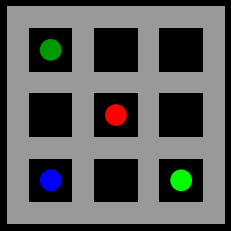

In [7]:
e = Environment(width, height, [0,0], [0,2], [2,0], [1,1])